In [1]:
%pylab inline
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy
import seaborn as sn

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Open mesh in ply format
def open_ply(filepath):
    f=open(filepath,'r');
    i=0;
    ip=0;
    it=0;
    np=0;
    nt=0;
    for str in f:
        i+=1;
        arr=str.split(" ");
        if(arr[0]=="element" and arr[1]=="vertex"):
            np=int(arr[2]);
            p=numpy.zeros((np,3));
        elif(arr[0]=="element" and arr[1]=="face"):
            nt=int(arr[2]);
            t=numpy.zeros((nt,3));
        elif(i>=11 and i<11+np):
            p[ip,0]=float(arr[0]);
            p[ip,1]=float(arr[1]);
            p[ip,2]=float(arr[2]);
            ip+=1;
        elif(i>=11+np and i<11+np+nt):
            t[it,0]=int(arr[1]);
            t[it,1]=int(arr[2]);
            t[it,2]=int(arr[3]);
            it+=1;
    mesh={};
    mesh["np"]=np;
    mesh["nt"]=nt;
    mesh["p"]=p;
    mesh["t"]=t;
    return mesh;

In [3]:
pathDesktop = '/Users/ghfc/Desktop/'

In [ ]:
# Load a trk file and extract the endpoints 
path = '/Users/ghfc/Desktop/Ferret_ExplDTI/P8_F10/'
fstreams = path+'filteredCentroids.trk'

from nibabel import trackvis
streams, hdr = trackvis.read(fstreams)
streamlines = [s[0] for s in streams]

endpoints=[]
i= 0

for i in range(len(streamlines)):
    stream = streamlines[i]
    
    endpoints.append(str(stream[0][0])+' '+str(stream[0][1])+' '+str(stream[0][2])+' '+str(stream[stream.shape[0]-1][0])+' '+str(stream[stream.shape[0]-1][1])+' '+str(stream[stream.shape[0]-1][2]))
    

In [128]:
# OR

In [4]:
# Load a txt file with the list of paired endpoints, such as each line has x y z of endpoint1 and x y z of endpoint2
fendpoints = pathDesktop+'P32_F16_endpoints_fit_paired.txt'
endpoints = np.loadtxt(fendpoints)

In [120]:
# Load the list of seed points for the spheres. Txt file, each line a x y z of a point
fpoints = pathDesktop+'testpoints.txt'
points = np.loadtxt(fpoints)


In [5]:
#OR
fpoints = pathDesktop+'P32-F16_as_F01_402.ply'
mesh = open_ply(fpoints)
points=mesh["p"]

A point (x,y,z) is inside the sphere with center (cx,cy,cz) and radius r
if:
 ( x-cx ) ^2 + (y-cy) ^2 + (z-cz) ^ 2 < r^2 

In [191]:
conMat = np.zeros((len(points),len(points)))

r = 2.5

start = -1
end = -1
countCon = 0
countNoCon = 0
ep = 0

for ep in range(len(endpoints)): #for each endpoint
    for p in range(len(points)): #check for each seed point
        #if the first endpoint is the sphere of radius r and center the point p
        if (pow(endpoints[ep,0]-points[p,0],2)+pow(endpoints[ep,1]-points[p,1],2)+pow(endpoints[ep,2]-points[p,2],2)<pow(r,2)):
            start=p
            #if both endpoints of a streamline were localised in one of the spheres then write in the connectivity matrix
            if (start!=-1 and end!=-1):
                #print endpoints[ep],points[start],points[end]
                conMat[start,end]+=1
                conMat[end,start]+=1
                countCon +=1
                
        #if the second (pair) endpoint is the sphere of radius r and center the point p        
        if (pow(endpoints[ep,3]-points[p,0],2)+pow(endpoints[ep,4]-points[p,1],2)+pow(endpoints[ep,5]-points[p,2],2)<pow(r,2)):
            end=p
            #if both endpoints of a streamline were localised in one of the spheres then write in the connectivity matrix
            if (start!=-1 and end!=-1):
                #print endpoints[ep],points[start],points[end]
                conMat[start,end]+=1
                conMat[end,start]+=1
                countCon +=1
                
    else:
        countNoCon +=1
    
    #reset for the next streamline
    start = -1
    end = -1

print 'nb of streamlines in the matrix',countCon
print 'nb of streamlines rejected from the matrix', countNoCon

nb of streamlines in the matrix 9371
nb of streamlines rejected from the matrix 2715


In [192]:
conMat

array([[ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  3., ...,  0.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  2.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  4.]])

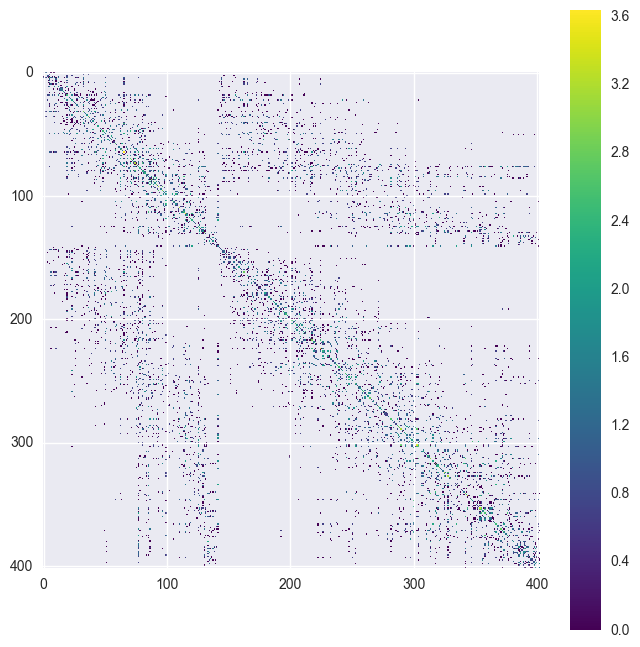

In [193]:
plt.figure(figsize=(8, 8))
plt.imshow(log(conMat),interpolation='nearest',cmap=plt.cm.viridis)
plt.colorbar()
fname = pathDesktop+'P32_F16_conmat_r'+str(r)+'.jpg'
#plt.savefig(fname)
plt.show()

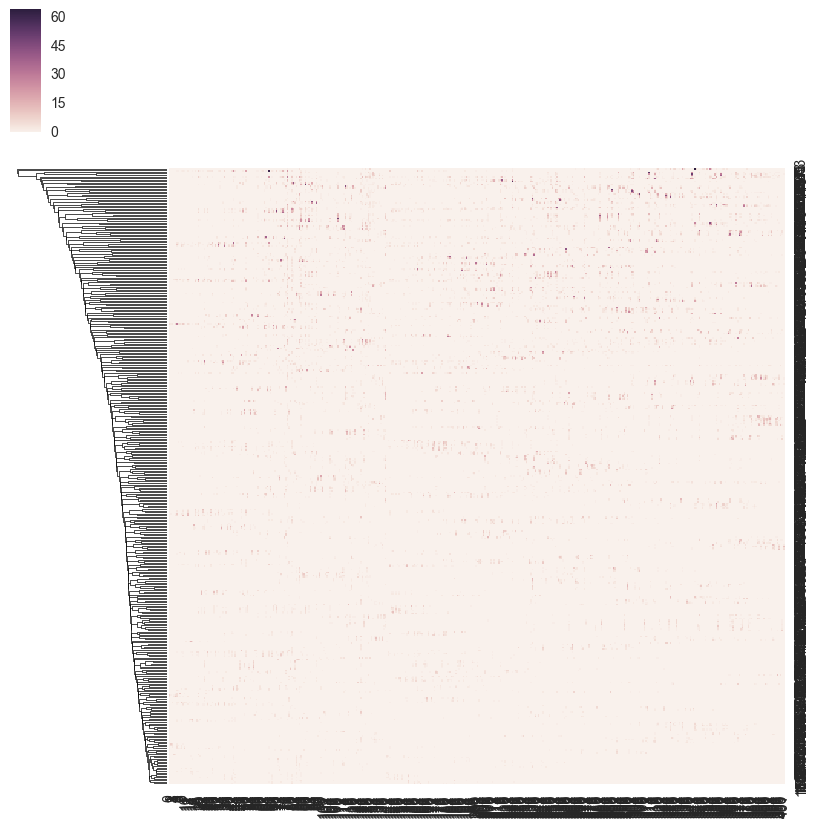

In [137]:
sn.clustermap(conMat,col_cluster=False)

Tutorial from: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [194]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(conMat,'ward')
#clust.hierarchy.fcluster(linkage,10)

In [183]:
#[idx1, idx2, dist, sample_count]
print Z.shape
Z[0:20]

(401, 4)


array([[ 223.        ,  225.        ,   32.23352292,    2.        ],
       [ 213.        ,  402.        ,   38.10074365,    3.        ],
       [  11.        ,   13.        ,   38.249183  ,    2.        ],
       [  18.        ,   20.        ,   41.32795664,    2.        ],
       [ 157.        ,  163.        ,   43.43961326,    2.        ],
       [ 344.        ,  349.        ,   44.27188724,    2.        ],
       [ 142.        ,  143.        ,   46.65833259,    2.        ],
       [ 330.        ,  333.        ,   47.18050445,    2.        ],
       [  43.        ,   60.        ,   50.61620294,    2.        ],
       [ 149.        ,  152.        ,   52.5832673 ,    2.        ],
       [  94.        ,   98.        ,   52.70673581,    2.        ],
       [ 229.        ,  403.        ,   53.92896562,    4.        ],
       [ 348.        ,  407.        ,   54.03702434,    3.        ],
       [ 159.        ,  161.        ,   56.25833272,    2.        ],
       [ 283.        ,  284.      

In [195]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(conMat))
c

0.76996717655671143

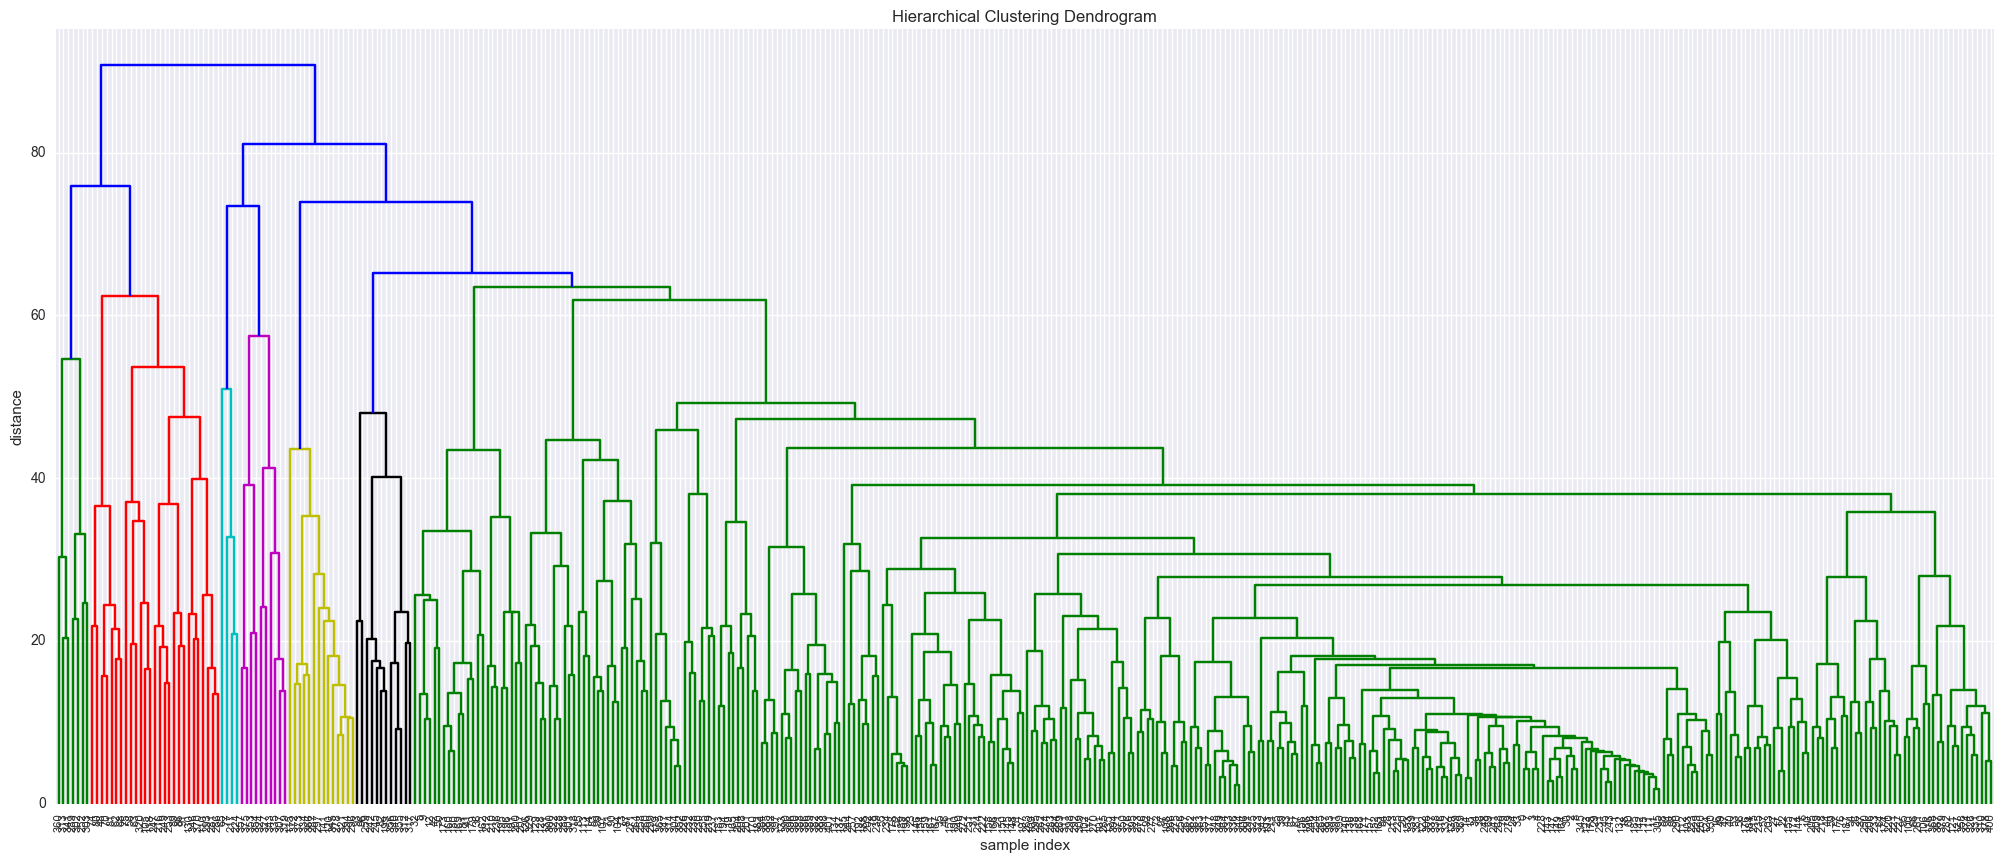

In [196]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

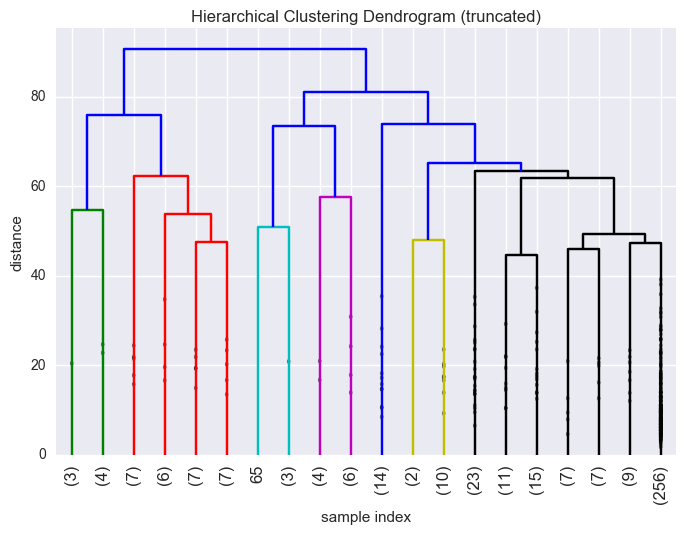

In [197]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    #show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [198]:
max_d = 0.7 * Z[:,2].max()
print max_d

63.4942210204


Extract clusters and create label file for EditMesh

In [187]:
from scipy.cluster.hierarchy import fcluster
max_d = 0.7 * max(Z[:,2])
clusters = fcluster(Z, max_d, criterion='distance')
clusters.max()

7

In [188]:
from pandas import DataFrame
label = DataFrame(clusters)

In [189]:
lnb = DataFrame([402])
label2 = DataFrame(concatenate([lnb,label]))

In [190]:
newfilename = 'labelsClusters'+str(max_d)+'.txt'
label2.to_csv(pathDesktop+newfilename, index=False, header=False, sep=' ')